### Benzene Prediction using Recurrent Neural Networks
<br><br>
<br>

### Load and Preprocess the Data
Here, the Air Quality dataset loaded and preprocessed to prepare it for training the models.The data is cleaned by handling missing values and scaled using StandardScaler. Here the dataset has been splited into training, validation, and test sets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU
import matplotlib.pyplot as plt
import requests
import zipfile
import io

In [ ]:
# Download the ZIP file
response = requests.get(url)
zipped_data = zipfile.ZipFile(io.BytesIO(response.content))


zipped_files = zipped_data.namelist()
csv_file = [file for file in zipped_files if file.endswith('.csv')][0]
with zipped_data.open(csv_file) as f:
    df = pd.read_csv(f, sep=';', decimal=',', na_values=-200)

# Drop NMHC(GT) feature due to many missing values
df.drop(columns=['NMHC(GT)'], inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [ ]:
# Impute missing values
# Forward fill missing values for consecutive missing observations
df.fillna(method='ffill', inplace=True)
# Backward fill remaining missing values
df.fillna(method='bfill', inplace=True)

df.drop(columns=['Date', 'Time'], inplace=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.shape


(9471, 12)

In [ ]:
# Select the columns of interest
input_columns = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']
target_column = 'C6H6(GT)'

# Standardize the input and target columns
scaling_input = StandardScaler()
df[input_columns] = scaling_input.fit_transform(df[input_columns])

scaling_target = StandardScaler()
df[target_column] = scaling_target.fit_transform(df[[target_column]])

# Spliting the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Converting to numpy arrays
X_train = train_df[input_columns].values
y_train = train_df[target_column].values
X_val = val_df[input_columns].values
y_val = val_df[target_column].values
X_test = test_df[input_columns].values
y_test = test_df[target_column].values

# Reshaping the input data to match the expected shape
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-5-cdfa71e65dcb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[input_columns] = scaler_input.fit_transform(df[input_columns])
<ipython-input-5-cdfa71e65dcb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_column] = scaler_target.fit_transform(df[[target_column]])


### Model Training
Here I experiment with one-step-ahead prediction using LSTM(Long Short-Term Memory) and GRU (Gated Recurrent Unit) models, analyzing the models performance in terms of loss and mean absolute error (MAE).Here The architecture of the models can be controlled by hyperparameters such as the number of units in the recurrent layer, the number of layers, dropout rates, etc.<br>

Model training involves teaching the model to predict the target variable based on the input data. In this step:<br>

* Data Preparation: The data is preprocessed by standardizing the input and target variables.Training data is split into training, validation, and test sets to ensure the model generalizes well.

* Training Process: The models are trained using an optimizer adam and loss function MSE.The training process involves feeding the input data to the model and updating the model parameters to minimize the loss function.Here the validation data is used to monitor the models performance and adjust hyperparameters if needed.



In [ ]:
# LSTM model for  prediction
model_lstm = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False),
    Dense(1)
])

# Compiling the model lstm
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training the model lstm
history_lstm = model_lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Creating a GRU model for one-step-ahead prediction
model_gru = Sequential([
    GRU(64, input_shape=(X_train.shape[1], 1), return_sequences=False),
    Dense(1)
])

# Compiling the model gru
model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training the model gru
history_gru = model_gru.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_val_reshaped, y_val))


Epoch 1/20
190/190 [==============================] - 4s 8ms/step - loss: 0.2408 - mae: 0.3238 - val_loss: 0.0966 - val_mae: 0.2258
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 0.0951 - mae: 0.2179 - val_loss: 0.0880 - val_mae: 0.2148
Epoch 3/20
190/190 [==============================] - 1s 5ms/step - loss: 0.0840 - mae: 0.2060 - val_loss: 0.0761 - val_mae: 0.1955
Epoch 4/20
190/190 [==============================] - 1s 5ms/step - loss: 0.0609 - mae: 0.1780 - val_loss: 0.0360 - val_mae: 0.1396
Epoch 5/20
190/190 [==============================] - 1s 5ms/step - loss: 0.0130 - mae: 0.0810 - val_loss: 0.0028 - val_mae: 0.0388
Epoch 6/20
190/190 [==============================] - 1s 5ms/step - loss: 0.0018 - mae: 0.0288 - val_loss: 9.8299e-04 - val_mae: 0.0224
Epoch 7/20
190/190 [==============================] - 1s 7ms/step - loss: 8.2129e-04 - mae: 0.0192 - val_loss: 5.0734e-04 - val_mae: 0.0167
Epoch 8/20
190/190 [==============================] - 1s 7ms/ste

### Loss Analysis
Here the current models go through 20 epochs to learn the data.During each epoch, the model calculates the training loss and mean absolute error (MAE). here the goal is to minimize these errors over time. As we know loss is a measure of how far off the models predictions are from the actual values, while MAE measures the average magnitude of the prediction errors.At the beginning of training (Epoch 1), both models start with high loss and MAE values for both training and validation data, indicating the models haven't learned much yet. As training progresses, you can see that both the loss and MAE for both training and validation data decrease significantly, indicating the models are learning the patterns in the data and improving their predictive performance.<br>

Here at the end of training on Epoch 20, the training and validation loss and MAE are all low, which is suggesting both models have converged and are performing well on both training and validation data. This indicates good generalization of this model.In the plot we can see that after certain point the validation loss dosen't have any visible change in that we can also use early stopping here to make the model more rubast.

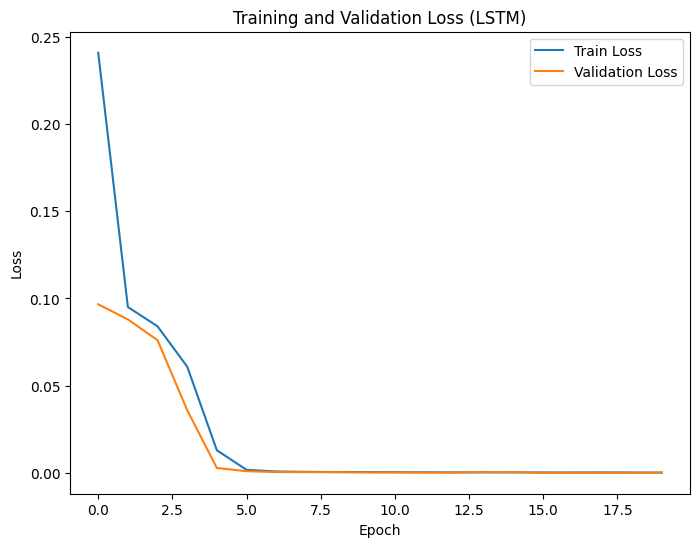

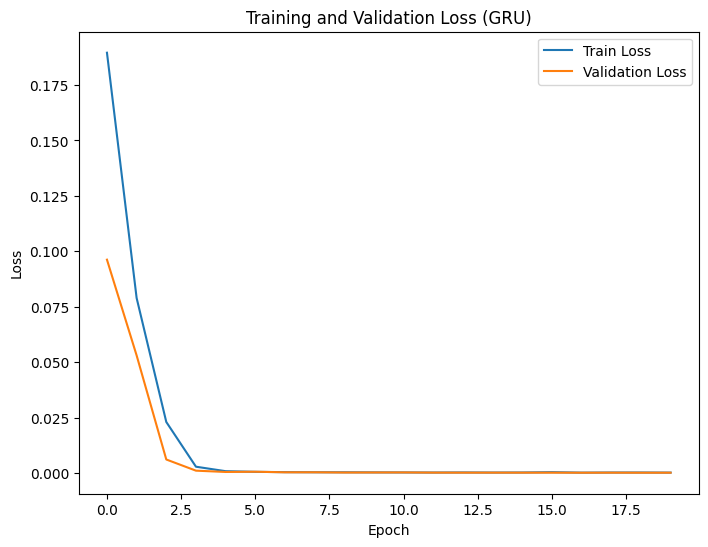

In [ ]:
# Plot training and validation loss for LSTM model
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.legend()
plt.show()

# Plot training and validation loss for GRU model
plt.figure(figsize=(8, 6))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (GRU)')
plt.legend()
plt.show()

In [ ]:
# Evaluate the prediction LSTM model
test_loss_lstm, test_mae_lstm = model_lstm.evaluate(X_test_reshaped, y_test)

# Evaluate the prediction GRU model
test_loss_gru, test_mae_gru = model_gru.evaluate(X_test_reshaped, y_test)

# Print the evaluation results
print(f"prediction (LSTM) - Loss: {test_loss_lstm:.4f}, MAE: {test_mae_lstm:.4f}")
print(f"prediction (GRU) - Loss: {test_loss_gru:.4f}, MAE: {test_mae_gru:.4f}")


60/60 [==============================] - 0s 2ms/step - loss: 0.0012 - mae: 0.0087
One-step-ahead prediction (LSTM) - Loss: 0.0014, MAE: 0.0116
One-step-ahead prediction (GRU) - Loss: 0.0012, MAE: 0.0087


### Result and Evalution
Here our goal is to predict the next value of benzene concentration based on the current value.Here the evalution of the predictions are:
##### LSTM Model Evalution
* Here as we can see from above the loss for LSTM is 0.0014, indicating how far off the models predictions are from the actual values. This low value suggests the model performs quite well.
* Here the MAE value for LSTM  is 0.0116, representing the average error between the predicted and actual values. A lower MAE indicates better performance.<br>

##### GRU Model Evalution
* Here the loss for GRU is 0.0012 which is slightly lower than the LSTM model, indicating the GRU model may be a better fit for the task with the "AirQuality" dataset.
* Here the MAE is 0.0087, which is lower than the LSTM model which is try to explain that the GRU model has a smaller average prediction error.

Here the lower loss and MAE for the GRU model compared to the LSTM model suggest that the GRU model considering perform better for the prediction task for the AirQuality dataset.As we can see from the plot where the Actual Value and predicted value has been overlapped.Here we can see that the predicted value and the actual values are quite closer for both model LSTM and GRU.

60/60 [==============================] - 1s 2ms/step


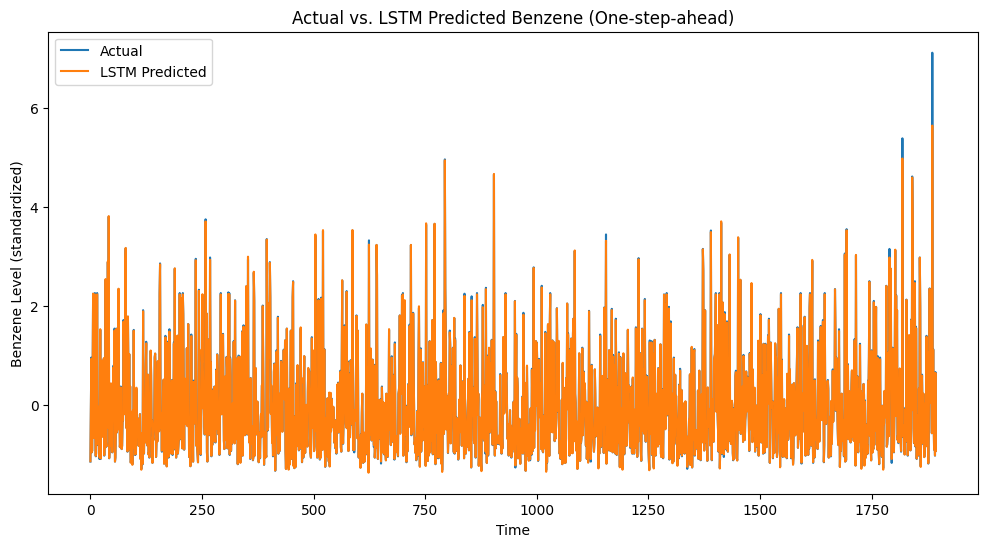

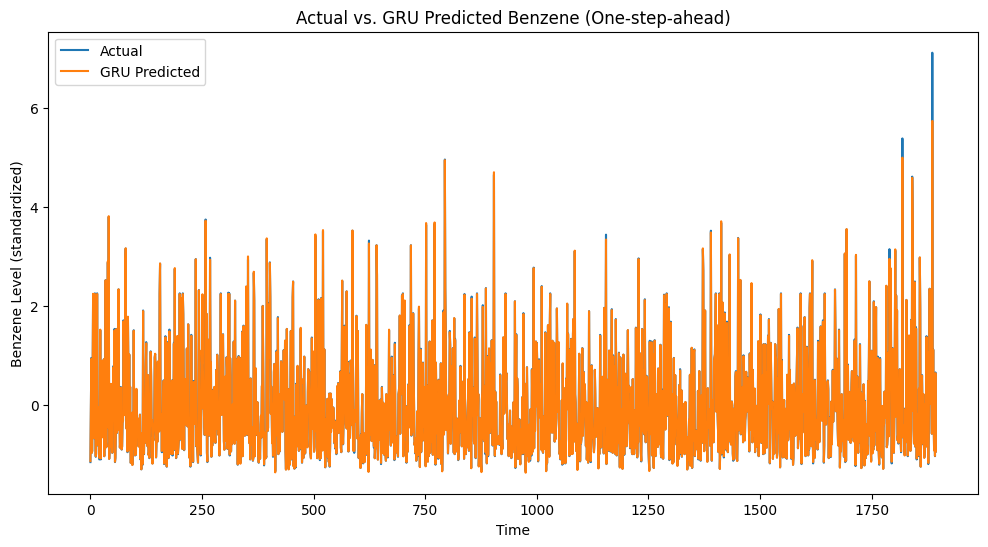

In [ ]:
# Make predictions with one-step-ahead prediction LSTM model
y_pred_lstm = model_lstm.predict(X_test_reshaped)

# Make predictions with one-step-ahead prediction GRU model
y_pred_gru = model_gru.predict(X_test_reshaped)

# Plot actual vs. predicted values for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lstm, label='LSTM Predicted')
plt.title('Actual vs. LSTM Predicted Benzene (One-step-ahead)')
plt.xlabel('Time')
plt.ylabel('Benzene Level (standardized)')
plt.legend()
plt.show()

# Plot actual vs. predicted values for GRU model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_gru, label='GRU Predicted')
plt.title('Actual vs. GRU Predicted Benzene (One-step-ahead)')
plt.xlabel('Time')
plt.ylabel('Benzene Level (standardized)')
plt.legend()
plt.show()
